<a href="https://colab.research.google.com/github/tylaar/notebook/blob/main/TRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
def compute_advantage(gamma, lmbda, td_delta):
  td_delta = td_delta.detach().numpy()
  advantage_list = []
  advantage = 0.0
  for delta in td_delta[::-1]:
    advantage = gamma * lmbda * advantage + delta
    advantage_list.append(advantage)
  advantage_list.reverse()
  return torch.tensor(advantage_list, dtype=torch.float)

In [15]:
import collections
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list


In [24]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


In [25]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [28]:
class TRPO:
  def __init__(self, hidden_dim, state_space, action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device):
    state_dim = state_space.shape[0]
    action_dim = action_space.n
    # policy part, manually controlled by TRPO iteration
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
    self.critic = ValueNet(state_dim, hidden_dim).to(device)
    self.critic_optimizer = torch.optim.Adam(
        self.critic.parameters(),
        lr=critic_lr)
    self.gamma = gamma
    self.alpha = alpha
    self.lmbda = lmbda
    self.kl_constraint = kl_constraint
    self.device = device

  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    probs = self.actor(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item()

  def hessian_matrix_vector_product(self, states, old_action_states, vector):
    new_action_dists = torch.distributions.Categorical(self.actor(states))
    kl = torch.mean(
        torch.distributions.kl.kl_divergence(
            old_action_states,
            new_action_dists)
    )
    kl_grad = torch.autograd.grad(kl,
                                  self.actor.parameters(),
                                  create_graph=True)
    kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
    # do dot product for kl_grad & target vector first to avoid storage of Hessian matrix
    kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
    grad2 = torch.autograd.grad(kl_grad_vector_product,
                                self.actor.parameters())
    grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
    return grad2_vector

  def conjugate_gradient(self, grad, states, old_action_dist):
    x = torch.zeros_like(grad)
    r = grad.clone()
    p = grad.clone()
    rtotr = torch.dot(r, r)
    for i in range(10):
      hp = self.hessian_matrix_vector_product(states, old_action_dist, p)
      alpha = rtotr / torch.dot(p, hp)
      x += alpha * p
      r -= alpha * hp
      new_rtotr = torch.dot(r, r)
      if new_rtotr < 1e-10:
        break
      beta = new_rtotr / rtotr
      p = r + beta * p
      rtotr = new_rtotr
    return x

  def compute_surrogate_obj(self, states, actions, advantage, old_log_probs, actor):
    log_probs = torch.log(actor(states).gather(1, actions))
    ratio = torch.exp(log_probs - old_log_probs)
    return torch.mean(ratio * advantage)

  def line_search(self, states, actions, advantage, old_log_probs, old_action_dists, max_vec):
    old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
        self.actor.parameters())
    old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
    for i in range(15): # blind setting
      coef = self.alpha ** i
      new_para = old_para + coef * max_vec
      new_actor = copy.deepcopy(self.actor)
      torch.nn.utils.convert_parameters.vector_to_parameters(
          new_para, new_actor.parameters()
      )
      new_action_dists = torch.distributions.Categorical(
          new_actor(states)
      )
      kl_div = torch.mean(
          torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists)
      )
      new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                           old_log_probs, new_actor)
      if new_obj > old_obj and kl_div < self.kl_constraint:
        return new_para
    return old_para


  def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):
    surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                               old_log_probs, self.actor)
    grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
    obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
    # conjugate action
    descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)

    # hessian
    hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
    max_coef = torch.sqrt(
        2 * self.kl_constraint /
        (torch.dot(descent_direction, hd) + 1e-8))
    new_para = self.line_search(states, actions, advantage, old_log_probs,
                                old_action_dists,
                                descent_direction * max_coef)
    torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

    # prepare data
    td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
    td_delta = td_target - self.critic(states)
    advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
    old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
    old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
    critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()  # update critic value
    # update actor policy level opt
    self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

Iteration 9: 100%|██████████| 50/50 [00:05<00:00,  9.99it/s, episode=500, return=147.400]


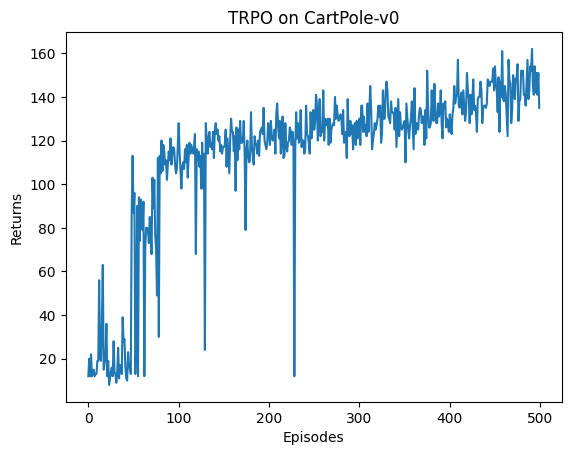

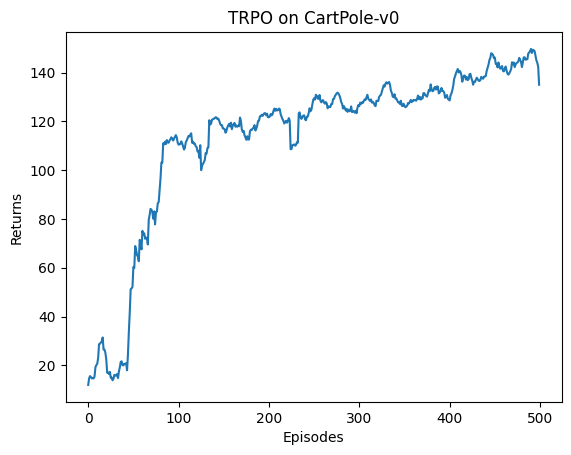

In [29]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()